<a href="https://colab.research.google.com/github/Ehtisham1053/Classification-ML-algorithms/blob/main/Random_forest_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Manual implementation without using the sklearn class

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA

In [10]:
class ManualRandomForest:
    def __init__(self, n_estimators=10, sample_size=0.8, max_depth=None, max_features=None):
        self.n_estimators = n_estimators
        self.sample_size = sample_size
        self.max_depth = max_depth
        self.max_features = max_features
        self.models = []
        self.subsets = []

    def fit(self, X, y):
        self.models = []
        self.subsets = []
        n_samples = int(self.sample_size * len(X))
        n_features = self.max_features if self.max_features else X.shape[1]

        for _ in range(self.n_estimators):
            indices = np.random.choice(len(X), n_samples, replace=True)
            feature_indices = np.random.choice(X.shape[1], n_features, replace=False)
            X_subset, y_subset = X[indices][:, feature_indices], y[indices]

            model = DecisionTreeClassifier(max_depth=self.max_depth)
            model.fit(X_subset, y_subset)
            self.models.append((model, feature_indices))
            self.subsets.append(indices)

    def predict(self, X):
        predictions = np.zeros((self.n_estimators, len(X)))
        for i, (model, feature_indices) in enumerate(self.models):
            predictions[i] = model.predict(X[:, feature_indices])

        # Majority voting for classification
        final_predictions = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=predictions)
        return final_predictions

    def evaluate(self, X_train, y_train, X_test, y_test):
        y_train_pred = self.predict(X_train)
        y_test_pred = self.predict(X_test)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        cm = confusion_matrix(y_test, y_test_pred)
        report = classification_report(y_test, y_test_pred)

        print("Training Accuracy:", train_acc)
        print("Testing Accuracy:", test_acc)
        print("Confusion Matrix:\n", cm)
        print("Classification Report:\n", report)

        pca = PCA(n_components=2)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        X_pca = pca.transform(X)

        xx, yy = np.meshgrid(np.linspace(X_pca[:,0].min()-1, X_pca[:,0].max()+1, 100),
                            np.linspace(X_pca[:,1].min()-1, X_pca[:,1].max()+1, 100))
        Z = manual_rf.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
        Z = Z.reshape(xx.shape)

        plt.figure(figsize=(8,6))
        plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
        sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='coolwarm', edgecolor='k')
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.title("Decision Boundary of Manual Random Forest")
        plt.show()

        plt.figure(figsize=(6,5))
        sns.heatmap(confusion_matrix(y_test, manual_rf.predict(X_test)), annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()


        # return train_acc, test_acc, cm, report

In [11]:
data = sns.load_dataset("penguins").dropna()
X = data.drop(columns=['species']).select_dtypes(include=[np.number]).values
y = data['species'].astype('category').cat.codes.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Training Accuracy: 0.9548872180451128
Testing Accuracy: 0.9850746268656716
Confusion Matrix:
 [[31  0  0]
 [ 1 12  0]
 [ 0  0 23]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        31
           1       1.00      0.92      0.96        13
           2       1.00      1.00      1.00        23

    accuracy                           0.99        67
   macro avg       0.99      0.97      0.98        67
weighted avg       0.99      0.99      0.98        67



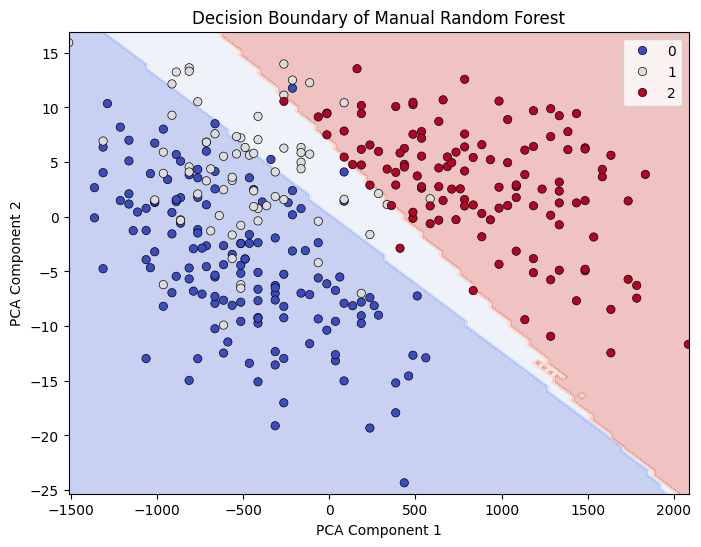

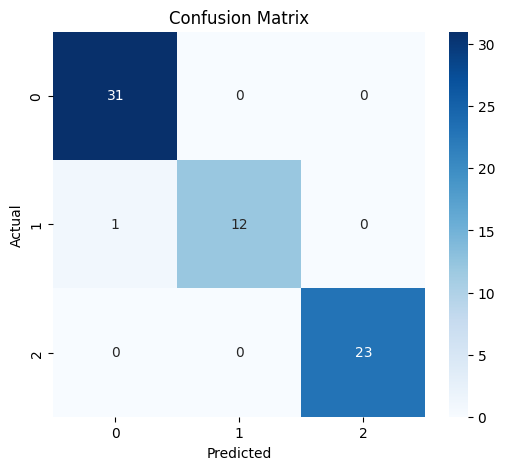

In [12]:
manual_rf = ManualRandomForest(n_estimators=5, sample_size=0.8, max_depth=3, max_features=2)
manual_rf.fit(X_train, y_train)
manual_rf.evaluate(X_train, y_train, X_test, y_test)

### Random Forest Explanation

# What is Random Forest?
Random Forest is an ensemble learning method that combines multiple decision trees to improve the accuracy and robustness of predictions. It is widely used for classification and regression tasks.

# How Does Random Forest Work?
Random Forest works by creating multiple decision trees using different subsets of data and features. The final prediction is obtained through majority voting (for classification) or averaging (for regression).

# Steps Involved in Random Forest (as Implemented in the Code)
1. **Bootstrap Sampling**:
   - We randomly select subsets of data (with replacement) to train each decision tree.
   - The sample size is determined by the `sample_size` parameter.

2. **Feature Selection**:
   - Each decision tree is trained using a randomly chosen subset of features (specified by `max_features`).
   - This reduces overfitting and improves generalization.

3. **Decision Tree Training**:
   - Each subset of data and selected features is used to train a separate decision tree.
   - Trees are trained with a specified maximum depth (`max_depth`).

4. **Prediction using Majority Voting**:
   - For classification, each tree predicts a class label.
   - The final prediction is the most frequently occurring class (majority vote) across all trees.

5. **Evaluation Metrics**:
   - The model calculates:
     - **Accuracy**: Measures the percentage of correct predictions.
     - **Confusion Matrix**: Shows the performance of the classifier by comparing actual and predicted labels.
     - **Classification Report**: Includes precision, recall, and F1-score.

6. **Visualization**:
   - **Decision Boundary Plot**:
     - We use **PCA** to reduce the features to 2 dimensions for visualization.
     - A contour plot is generated to show the decision boundaries of the Random Forest classifier.
   - **Confusion Matrix Plot**:
     - A heatmap is plotted to visualize how well the model classifies the test data.

# Why Does Random Forest Work Well?
- Reduces overfitting compared to a single decision tree.
- Handles high-dimensional data efficiently.
- Provides feature importance ranking.
- Works well even when data contains noise or missing values.

# Where to Use Random Forest?
- **Classification Tasks**: Image classification, fraud detection, medical diagnosis.
- **Regression Tasks**: House price prediction, stock market forecasting.
- **Feature Selection**: Identifies important features for predictive modeling.

Random Forest is a powerful and flexible model, making it one of the most widely used machine learning algorithms in practice.


# implementation using the sklearn class

Training Accuracy: 0.9962406015037594
Testing Accuracy: 1.0
Confusion Matrix:
 [[31  0  0]
 [ 0 13  0]
 [ 0  0 23]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        23

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67



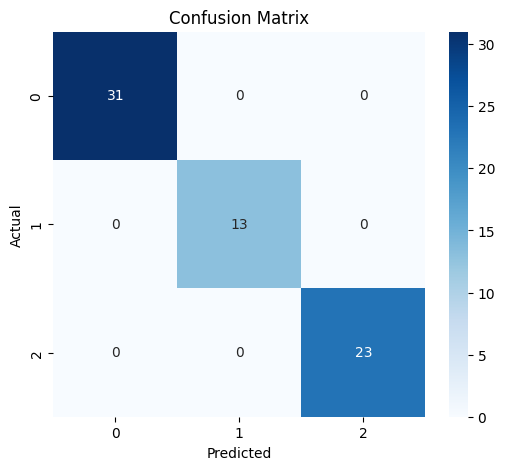

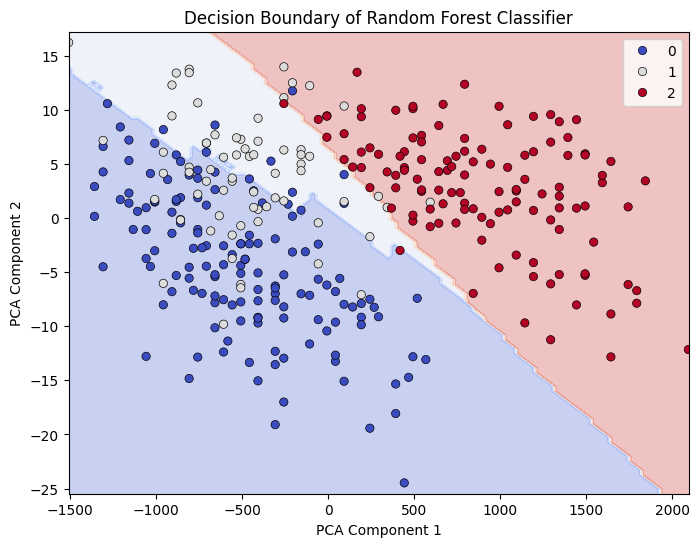

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA

class RandomForestModel:
    def __init__(self, n_estimators=50, max_depth=5, max_features='sqrt', random_state=42):
        self.model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                            max_features=max_features, random_state=random_state)

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X):
        return self.model.predict(X)

    def evaluate(self, X_train, y_train, X_test, y_test):
        y_train_pred = self.predict(X_train)
        y_test_pred = self.predict(X_test)

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        cm = confusion_matrix(y_test, y_test_pred)
        report = classification_report(y_test, y_test_pred)

        print("Training Accuracy:", train_acc)
        print("Testing Accuracy:", test_acc)
        print("Confusion Matrix:\n", cm)
        print("Classification Report:\n", report)

        self.plot_confusion_matrix(cm, y_test)

        return train_acc, test_acc, cm, report

    def plot_confusion_matrix(self, cm, y_test):
        labels = np.unique(y_test)  # Get unique class labels
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    def plot_decision_boundary(self, X, y):
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        xx, yy = np.meshgrid(np.linspace(X_pca[:,0].min()-1, X_pca[:,0].max()+1, 100),
                             np.linspace(X_pca[:,1].min()-1, X_pca[:,1].max()+1, 100))
        Z = self.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
        Z = Z.reshape(xx.shape)

        plt.figure(figsize=(8,6))
        plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
        sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='coolwarm', edgecolor='k')
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.title("Decision Boundary of Random Forest Classifier")
        plt.show()




Training Accuracy: 0.9962406015037594
Testing Accuracy: 1.0
Confusion Matrix:
 [[31  0  0]
 [ 0 13  0]
 [ 0  0 23]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        23

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67



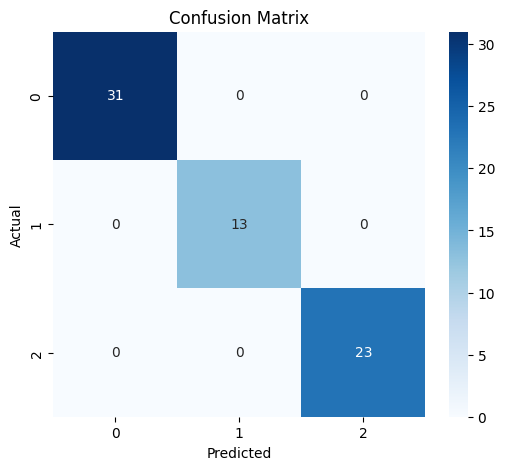

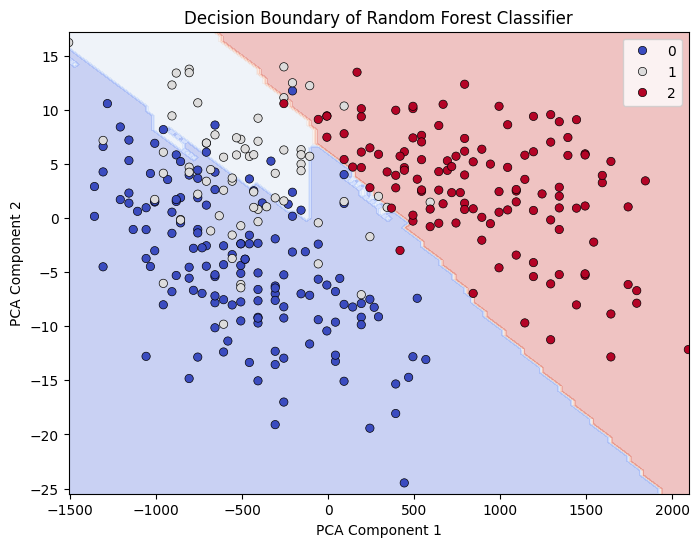

In [16]:
data = sns.load_dataset("penguins").dropna()
X = data.drop(columns=['species']).select_dtypes(include=[np.number]).values
y = data['species'].astype('category').cat.codes.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestModel(n_estimators=10, max_depth=5, max_features='sqrt', random_state=42)
rf_model.fit(X_train, y_train)
rf_model.evaluate(X_train, y_train, X_test, y_test)
rf_model.plot_decision_boundary(X, y)